<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Infectious-Non-Linear-Example" data-toc-modified-id="Infectious-Non-Linear-Example-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Infectious Non Linear Example</a></span></li></ul></div>

## Infectious Non Linear Example

In [1]:
import pandas as pd
import numpy as np
from scipy import sparse
from typing import List, Tuple
import pyomo.environ as pyo

Simulate the outbreak of an infectious disease on a 1000. 

Standard Discrete Time Compartment model to represent the system. individuals separated into 3 compartments

$$I: \text{Infected}$$
$$S: \text{Susceptible}$$
$$R: \text{Recovered}$$
$$N: \text{Population Size}$$

It is assumed that all infected people on t are not Susceptible nor Infected in t+1

$$I_{i} = \frac{\beta{}I_{i-1}^\alpha{}S_{i-1}}{N}$$
$$S_{i} = S_{i-1}-I_i$$

Parameters to estimate: $\alpha{}$, $\beta{}$

Using Least Square to estimate the parameters, the problem statement will be as follows:
$$C_i: \text{Reported cases at time i}$$
$$SI: \text{Serial interval (Time steps)}$$

**Problem Formulation**
$$\min\limits_{\alpha, \beta} \sum_{i \in SI}(\varepsilon_i^{I})^2 \hspace{1ex}(1)$$
$$s.t.$$
$$I_{i} = \frac{\beta{}I_{i-1}^\alpha{}S_{i-1}}{N}, \forall i \in SI \hspace{1ex}(2)$$
$$S_{i} = S_{i-1}-I_i, \forall i \in SI \hspace{1ex}(3)$$
$$C_i = I_i +  \varepsilon_i^{I} \hspace{1ex}(4)$$
$$I_i \geq 0 \hspace{1ex}(5)$$
$$S_i \leq N \hspace{1ex}(6)$$
$$0.5 \leq \beta{} \leq 70 \hspace{1ex}(7)$$
$$0.5 \leq \alpha{} \leq 4.5 \hspace{1ex}(8)$$

In [50]:
model = AbstractModel("Disease")

model.S_SI = Set(ordered=True) # Time steps

model.P_REP_CASES = Param(model.S_SI) # Param reported cases for each time step
model.P_POP = Param() # Population

model.I = Var(model.S_SI, bounds=(0,model.P_POP), initialize=1) # Infected People on each time step
model.S = Var(model.S_SI, bounds=(0,model.P_POP), initialize=1000) # Susceptible People on each time step

# Variables
model.beta = Var(bounds=(0.05, 70))
model.alpha = Var(bounds=(0.5, 4.5)) 
model.eps_I = Var(model.S_SI, initialize=0.0) # Error at each time step

def _objective(model):
    return sum((model.eps_I[i])**2 for i in model.S_SI)
model.objective = Objective(rule=_objective, sense=minimize)

# Dynamics Constraint (2)
def _InfDynamics(model, i):
    if i != 1:
        return model.I[i] == (model.beta * model.S[i-1]*model.I[i-1]**model.alpha)/model.P_POP
    return Constraint.Skip
model.InfDynamics = Constraint(model.S_SI, rule=_InfDynamics)

# Dynamics Constrain (3)
def _SusDynamics(model, i):
    if i != 1:
        return model.S[i] == model.S[i-1] - model.I[i]
    return Constraint.Skip
model.SusDynamics = Constraint(model.S_SI, rule=_SusDynamics)

# Should Match Reality (4)
def _Data(model, i):
    return model.P_REP_CASES[i] == model.I[i] + model.eps_I[i]
model.Data = Constraint(model.S_SI, rule=_Data)


# Callback To print Beta and Alpha
def pyomo_postprocess(options=None, instance=None, results=None):

    print('Optimal beta Value: {}'.format(instance.beta.value))
    print('Optimal alpha Value: {}'.format(instance.alpha.value))

In [51]:
file_body = """
# disease_estimation.dat

set S_SI := 1 2 3 4 5 6 7 8 9 10 11 12 13 14
15 16 17 18 19 20 21 22 23 24 25 26 ;
param P_POP := 1000.000000;
param P_REP_CASES default 0.0 :=
1 1.000000
2 2.000000
3 5.000000
4 11.000000
5 19.000000
6 38.000000
7 75.000000
8 120.000000
9 136.000000
10 108.000000
11 83.000000
12 66.000000
13 40.000000
14 28.000000
15 20.000000
16 13.000000
17 6.000000
18 3.000000
19 0.000000
20 2.000000
;
"""

with open("disease_estimation.dat", "w") as file:
    file.write(
        file_body)

In [52]:
instance = model.create_instance("disease_estimation.dat")
solver = SolverFactory('ipopt')
solver.solve(instance)

{'Problem': [{'Lower bound': -inf, 'Upper bound': inf, 'Number of objectives': 1, 'Number of constraints': 76, 'Number of variables': 80, 'Sense': 'unknown'}], 'Solver': [{'Status': 'ok', 'Message': 'Ipopt 3.12.13\\x3a Optimal Solution Found', 'Termination condition': 'optimal', 'Id': 0, 'Error rc': 0, 'Time': 0.39563488960266113}], 'Solution': [OrderedDict([('number of solutions', 0), ('number of solutions displayed', 0)])]}

In [53]:
instance.display()

Model Disease

  Variables:
    I : Size=26, Index=S_SI
        Key : Lower : Value                 : Upper  : Fixed : Stale : Domain
          1 :     0 : 0.0030357147646931275 : 1000.0 : False : False :  Reals
          2 :     0 :    0.0785907233540594 : 1000.0 : False : False :  Reals
          3 :     0 :    0.8489849130746153 : 1000.0 : False : False :  Reals
          4 :     0 :     4.835753407462108 : 1000.0 : False : False :  Reals
          5 :     0 :    17.178452416204117 : 1000.0 : False : False :  Reals
          6 :     0 :     42.66486491651755 : 1000.0 : False : False :  Reals
          7 :     0 :     79.36878208260845 : 1000.0 : False : False :  Reals
          8 :     0 :    114.35931856582744 : 1000.0 : False : False :  Reals
          9 :     0 :    129.39947501316402 : 1000.0 : False : False :  Reals
         10 :     0 :    116.89307374131431 : 1000.0 : False : False :  Reals
         11 :     0 :     87.76594205419636 : 1000.0 : False : False :  Reals
        

In [54]:
pyomo_postprocess(options=None, instance=instance, results=None)

Optimal beta Value: 5.455950618916311
Optimal alpha Value: 0.7314098570421634


In [55]:
S_array = [val.value for val in instance.S.values()]
I_array = [val.value for val in instance.I.values()]
eps_array = [val.value for val in instance.eps_I.values()]
ts_array = [val for val in instance.S_SI.values()]
Reported_array = [val for val in instance.P_REP_CASES.values()]

In [56]:
df = pd.DataFrame({"S": S_array, "ts": ts_array, "I": I_array, "eps": eps_array, "Reported": Reported_array})

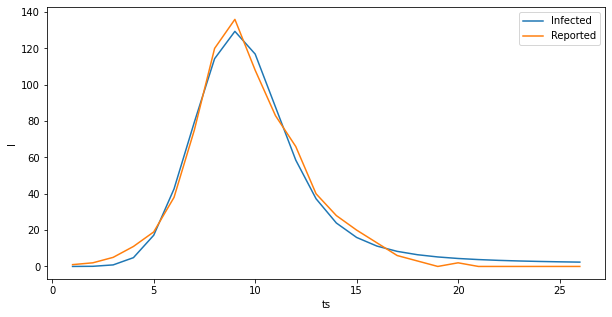

In [57]:
fig, ax = plt.subplots(figsize=(10,5))
#sns.lineplot(data=df, x="ts", y="S", ax=ax, label="S")
sns.lineplot(data=df, x="ts", y="I", ax=ax, label="Infected")
sns.lineplot(data=df, x="ts", y="Reported", ax=ax, label="Reported")
ax.legend()
plt.show()

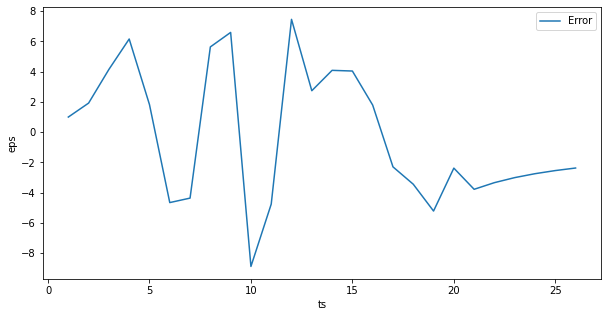

In [58]:
fig, ax = plt.subplots(figsize=(10,5))
sns.lineplot(data=df, x="ts", y="eps", label="Error", ax=ax)
plt.show()

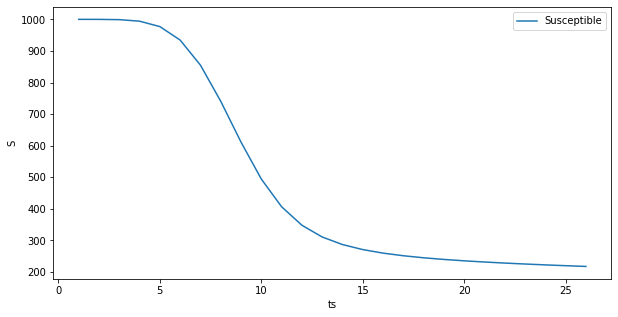

In [59]:
fig, ax = plt.subplots(figsize=(10,5))
sns.lineplot(data=df, x="ts", y="S", label="Susceptible", ax=ax)
plt.show()

**Reference**
- Hart, William E., Carl D. Laird, Jean-Paul Watson, David L. Woodruff, Gabriel A. Hackebeil, Bethany L. Nicholson, and John D. Siirola. Pyomo – Optimization Modeling in Python. Second Edition.  Vol. 67. Springer, 2017.